In [152]:
# Используется тот же датасет, что и в предыдущей работе
# Инициализация

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import silhouette_score

pd.set_option("display.max_columns", 10)
pd.set_option("display.width", 200)

columns = ["Store", "Weekly_Sales", "Holiday_Flag", "Temperature", "Fuel_Price", "CPI", "Unemployment"]

df = pd.read_csv("Walmart_Sales.csv")

In [146]:
# Добавление нового аттрибута
# %_Of_Sales, который отражает % от общей суммы проданных товаров за неделю

columns.append("%_Of_Sales")
df_augmented = df.copy()
df_augmented["%_Of_Sales"] = 100 * df_augmented["Weekly_Sales"] / df_augmented.groupby("Date")["Weekly_Sales"].transform("sum")

In [147]:
# "Причесывание" датасета
# Удаление дублей

# Поскольку ключевые поля это id магазина и дата, то надо удалять дубли по этим столбцам
df_augmented = df_augmented.drop_duplicates(subset=["Store", "Date"])

# Удаление выбросов

for column in columns:
    Q1 = df_augmented[column].quantile(0.25)
    Q3 = df_augmented[column].quantile(0.75)
    IQR = Q3 - Q1
    lbound = Q1 - 1.5 * IQR
    ubound = Q3 + 1.5 * IQR
    df_augmented = df_augmented[(df_augmented[column] >= lbound) & (df_augmented[column] <= ubound)]
    
# В прошлой работе выяснено, что пропущенных значений нет, поэтому их обрабатывать не требуется

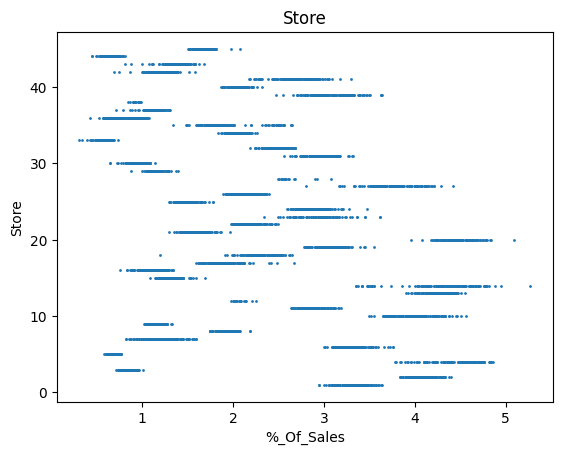

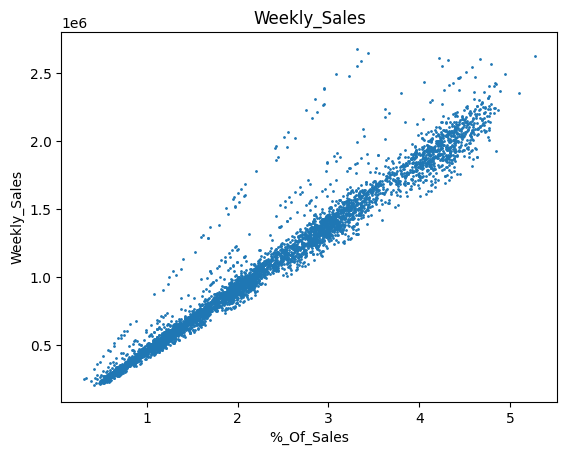

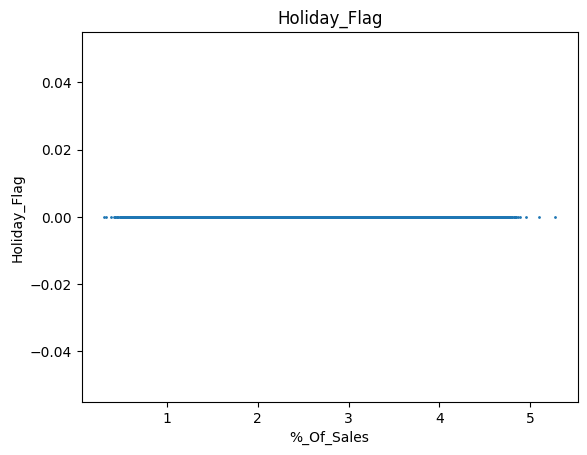

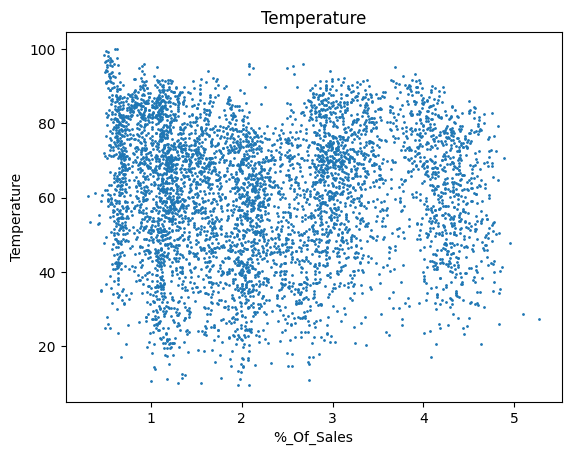

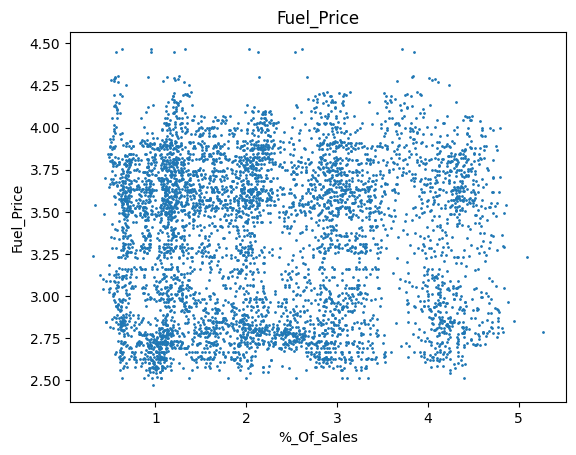

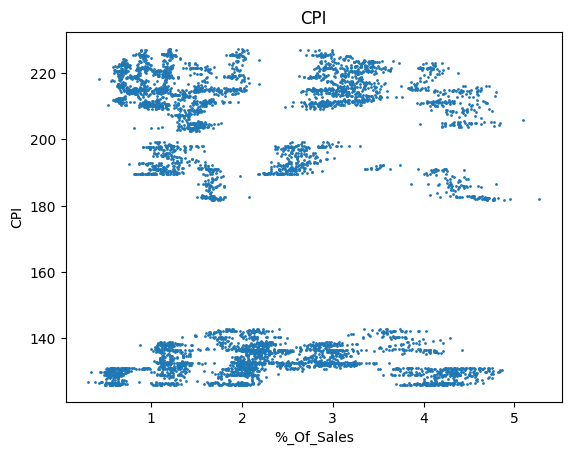

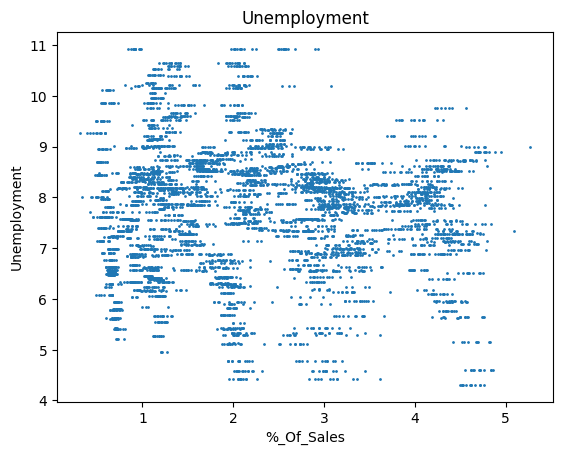

In [148]:
# Графики зависимости величин от %_Of_Sales

for column in columns:
    if column == "%_Of_Sales":
        continue
    plt.scatter(df_augmented["%_Of_Sales"], df_augmented[column], s=1)
    plt.title(column)
    plt.xlabel("%_Of_Sales")
    plt.ylabel(column)
    plt.show()

In [ ]:
На графиках можно заметить группы:
- с низкими продажами (и % продаж соответственно) 
    и наоборот, с высокими, а также промежуточное значение
- с высокой ценой на топливо и низким % продаж, 
    низкой ценой на топливо и низким % продаж и оставшееся
- с низким CPI, высоким CPI и % продаж и высоким CPI и низким % продаж
- с низким % продаж, средним уровнем безработицы и остальное

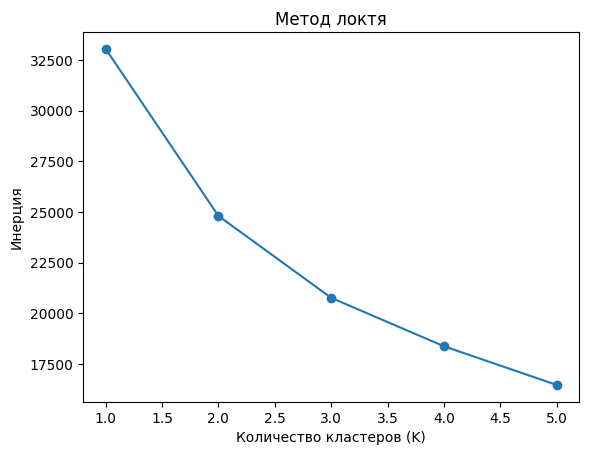

In [161]:
# Метод K-Means

# Признаки для кластеризации
features = ["Weekly_Sales", "Temperature", "Fuel_Price", "CPI", "Unemployment", "%_Of_Sales"]
X = df_augmented[features].copy()

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Определение K
inertias = []
krange = range(1, 6)

for k in krange:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure()
plt.plot(krange, inertias, marker="o")
plt.title("Метод локтя")
plt.xlabel("Количество кластеров (K)")
plt.ylabel("Инерция")
plt.show()

In [177]:
# Из графика видно, что резкое уменьшение инерции заканчивается при K = 2

# Применение метода K-Means
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df_augmented["cluster"] = kmeans.fit_predict(X_scaled)

# Характеристика кластеров
for i in range(2):
    cluster = df_augmented[df_augmented["cluster"] == i]
    print("\nКластер", i)
    print("Кол-во объектов =", len(cluster))
    for feature in features:
        print(f"Среднее {feature} = {cluster[feature].mean():.3f}")


Кластер 0
Кол-во объектов = 2112
Среднее Weekly_Sales = 1631123.264
Среднее Temperature = 62.571
Среднее Fuel_Price = 3.364
Среднее CPI = 177.207
Среднее Unemployment = 7.492
Среднее %_Of_Sales = 3.489

Кластер 1
Кол-во объектов = 3395
Среднее Weekly_Sales = 665333.288
Среднее Temperature = 60.397
Среднее Fuel_Price = 3.341
Среднее CPI = 173.666
Среднее Unemployment = 7.859
Среднее %_Of_Sales = 1.431


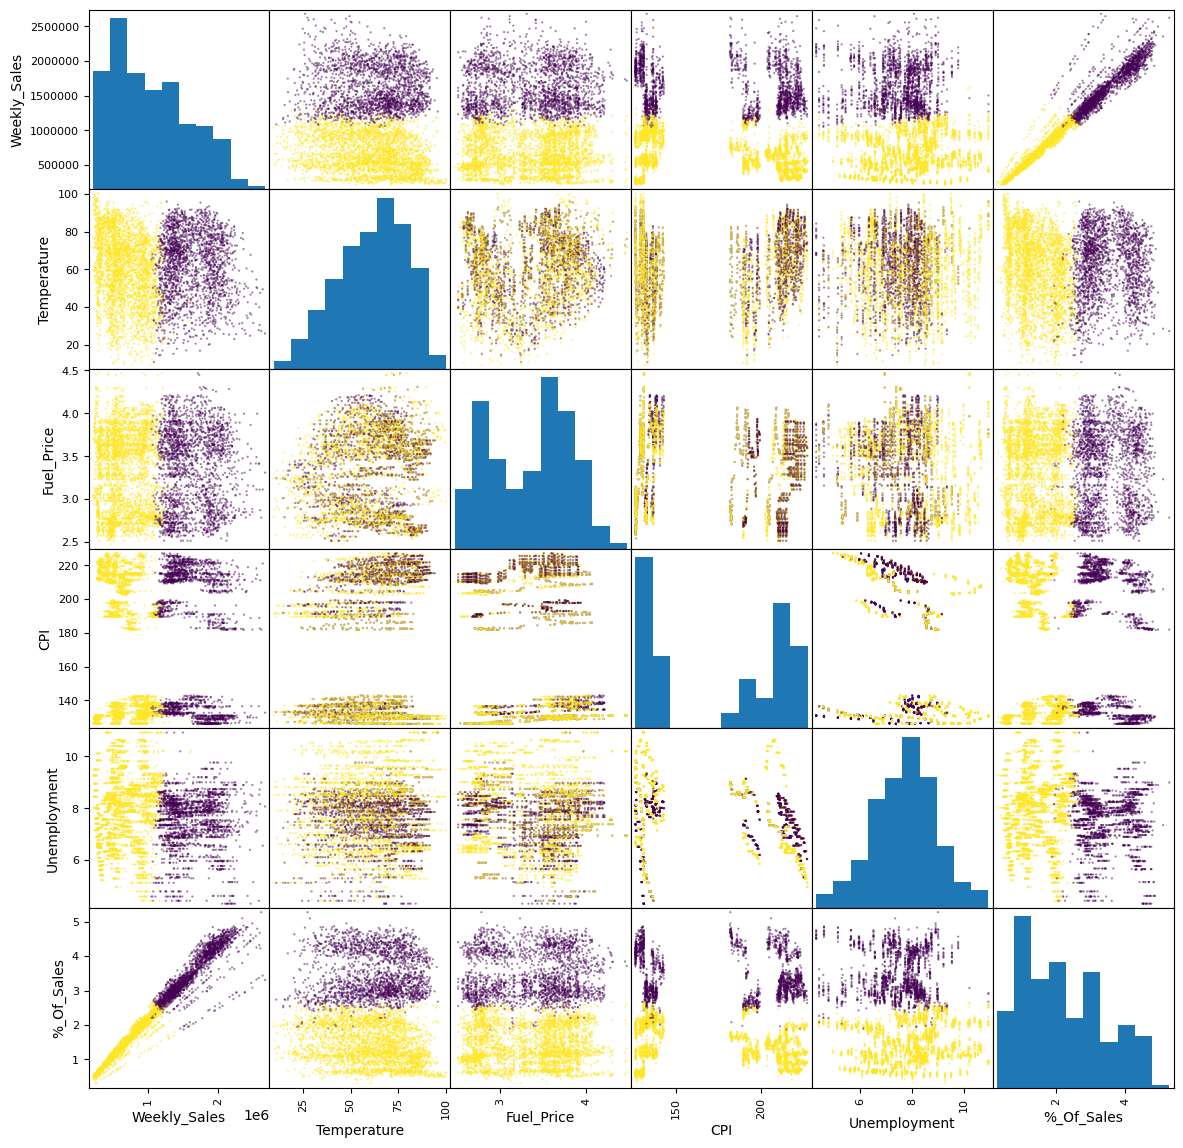

In [180]:
# Визуализация

pd.plotting.scatter_matrix(df_augmented[features], figsize=(14,14), c=df_augmented["cluster"], s=10)
plt.show()

In [ ]:
Вывод

В ходе выполнения лабораторной работы был добавлен новый аттрибут в датасет "%_Of_Sales",
который отражает % от общей суммы проданных товаров за неделю.
Произошло знакомство с методом K-Mean. Выявлены два кластера, один содержит
магазины с высокими суммами продаж, второй наоборот, с низкими